In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)
%matplotlib inline

import sys
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import data, io
from skimage.transform import resize
from skimage.color.colorconv import rgb2grey
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the label file

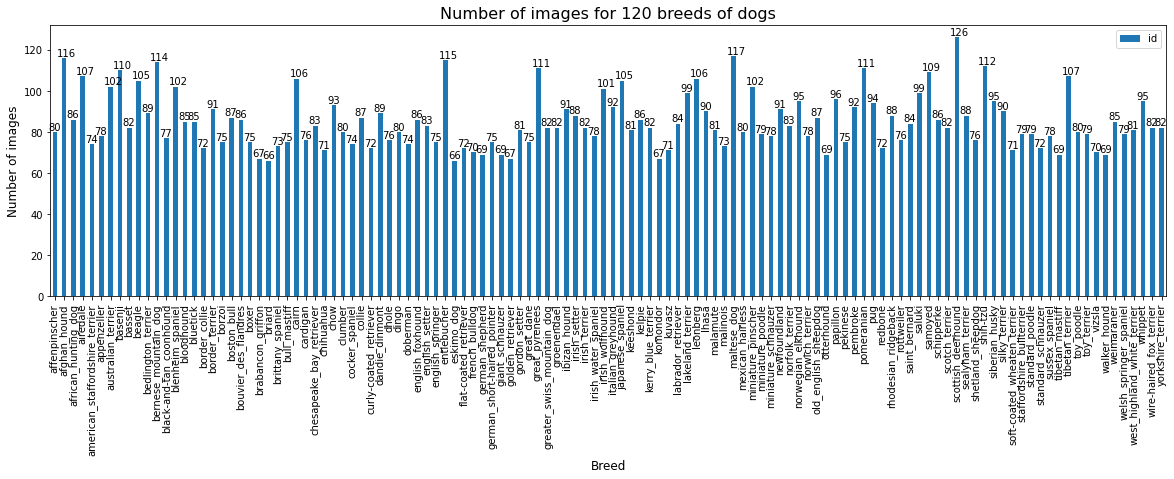

In [ ]:
#read ordered labels from CSV file 
labels = pd.read_csv("/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/labels.csv")
coun = labels.groupby('breed').count()
coun.plot(kind = 'bar', figsize = (20, 5))
plt.ylabel('Number of images', fontsize = 12)
plt.xlabel('Breed', fontsize = 12)
plt.title("Number of images for 120 breeds of dogs", fontsize = 16)

for i, v in enumerate(coun['id']):
  plt.text(i-0.75, v+1, str(v))

### Identify 20 different breeds with 100 image or above

In [ ]:
# Find 20 categories with 100 image or above
img100 = coun['id'].sort_values(ascending = False)[0:20]
img100_idx = img100.index.sort_values()
print("Total images number of 20 categories with 100 images or above:\n", img100.sum())
print("\n 20 categories with 100 images or above:\n", img100_idx)

Total images number of 20 categories with 100 images or above:
 2184

 20 categories with 100 images or above:
 Index(['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle',
       'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher',
       'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg',
       'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed',
       'scottish_deerhound', 'shih-tzu', 'tibetan_terrier'],
      dtype='object', name='breed')


['basenji' 'scottish_deerhound' 'maltese_dog' 'cairn' 'tibetan_terrier'
 'shih-tzu' 'australian_terrier' 'samoyed' 'entlebucher' 'airedale'
 'leonberg' 'bernese_mountain_dog' 'afghan_hound' 'miniature_pinscher'
 'irish_wolfhound' 'great_pyrenees' 'beagle' 'japanese_spaniel'
 'pomeranian' 'blenheim_spaniel']
                                  id               breed
8   003df8b8a8b05244b1d920bb6cf451f9             basenji
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
12  00693b8bc2470375cc744a6391d397ec         maltese_dog
29  00bee065dcec471f26394855c5c2f3de               cairn
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier


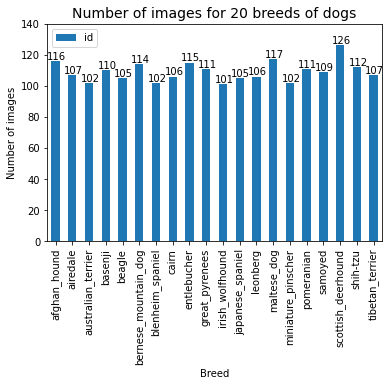

In [ ]:
# Identify the filenames for these 20 categories
sub_data = labels[labels['breed'].isin(img100_idx)]
img100_id = sub_data['id']
print(sub_data['breed'].unique())
print(sub_data.head())

breeds20 = sub_data.groupby('breed').count()
breeds20.plot(kind = 'bar', figsize = (6, 4))
plt.ylabel('Number of images', fontsize = 10)
plt.xlabel('Breed', fontsize = 10)
plt.yticks(np.arange(0, 160, 20))
plt.title("Number of images for 20 breeds of dogs", fontsize = 14)

for i, v in enumerate(breeds20['id']):
  plt.text(i-0.5, v+1, str(v))

### Load images

In [ ]:
# Create a list containing all the selected files and their directories
path = '/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/'
img100_files = [path+i+'.jpg' for i in img100_id]
img100_files[0:5]

['/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 '/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00693b8bc2470375cc744a6391d397ec.jpg',
 '/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00bee065dcec471f26394855c5c2f3de.jpg',
 '/content/drive/Shareddrives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg']

In [ ]:
# Load images
imgs = []
for pic in img100_files[0:]:
    img = io.imread(pic)
    imgs.append(img)

images = np.asarray(imgs)

## Machine Learning

### Resize the images and prepare for machine learning model

In [ ]:
# Find the resize shape
IMG_RDIM = min([images[j].shape[0] for j in range(images.shape[0])])
IMG_CDIM = min([images[k].shape[1] for k in range(images.shape[0])])
IMG_RGB = min([images[l].shape[2] for l in range(images.shape[0])])
print(IMG_RDIM, IMG_CDIM, IMG_RGB)

IMG_DIM = min(IMG_RDIM, IMG_CDIM)
print(IMG_DIM)

103 97 3
97


(500, 474, 3)


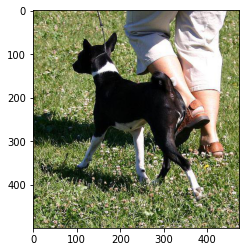

In [ ]:
img0 = images[0]
print(img0.shape)
plt.imshow(img0)

(97, 97, 3)


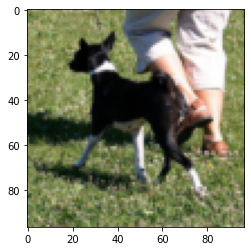

In [ ]:
resized_img0 = resize(images[0], (97, 97))
print(resized_img0.shape)
plt.imshow(resized_img0)

In [ ]:
# Resize the shape and prepare data for machine learning models
images_resized_ml = []

for pic in images:
  #img_grey = rgb2grey(pic)
  #img_resized = resize(img_grey, (IMG_DIM, IMG_DIM))
    img_resized = resize(pic, (IMG_DIM, IMG_DIM))
    images_resized_ml.append(img_resized.ravel())

images_resized_ml = np.asarray(images_resized_ml)

In [ ]:
images_resized_ml.shape

(2184, 28227)

### Prepare label data for model

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files:
    base = os.path.basename(pic)
    filename = os.path.splitext(base)[0]
    files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

(2184, 2)

### Train Test Split

In [ ]:
# Split train and test
X_ml = images_resized_ml
y_ml = df_labels['breed']

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size = 0.3, random_state = 42)
print(X_ml.shape, y_ml.shape)
print(X_train_ml.shape, X_test_ml.shape)
print(y_train_ml.shape, y_test_ml.shape)

(2184, 28227) (2184,)
(1528, 28227) (656, 28227)
(1528,) (656,)


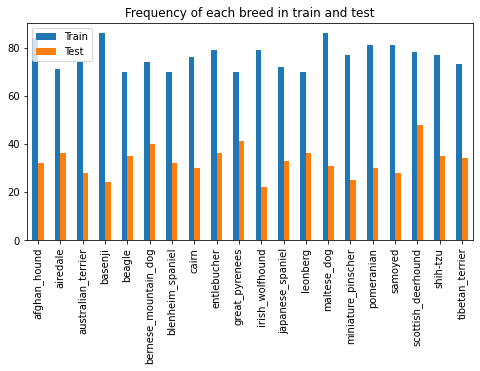

In [ ]:
df_y_train_ml = pd.Series(y_train_ml.value_counts(), name = 'Train')
df_y_test_ml = pd.Series(y_test_ml.value_counts(), name = 'Test')
df_ml = pd.concat([df_y_train_ml, df_y_test_ml], axis = 1, sort = True)
df_ml.plot(kind = 'bar', figsize = (8, 4), title = 'Frequency of each breed in train and test')
plt.show()

### Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Declare parameters
N_ESTIMATORS = 100
CV = 3

C_range = [1e-2, 1e1, 1e3, 1e5]
# gamma_range = [1e-4, 1e-2, 1, 1e2, 1e4]
# degree_range = [2,3,4]
# learning_rate_range = [0.001, 0.01, 0.1]

rf_param_grid = [
                 {'max_depth':[20, 30, 40]}                  
]

In [ ]:
# Define classifiers
classifiers = {'Logistic Regression': GridSearchCV(LogisticRegression(random_state = 23, multi_class = 'multinomial', max_iter = 500), 
                                                   param_grid = [{'C': C_range}], cv = CV),
               
               'Random Forest': GridSearchCV(RandomForestClassifier(n_estimators = N_ESTIMATORS, random_state = 23), 
                                             param_grid = rf_param_grid, cv = CV)}

In [ ]:
metrics = pd.DataFrame(columns = ['Classifier', 'Train Score', 'Test Score'])

In [ ]:
# Fit model
for name, clf in classifiers.items():
    print('Fitting', name)
    
    clf.fit(X_train_ml, y_train_ml)
    bst_clf = clf.best_estimator_
    
    y_pred_train_ml = bst_clf.predict(X_train_ml)
    y_pred_test_ml = bst_clf.predict(X_test_ml)
    
    train_score = accuracy_score(y_train_ml, y_pred_train_ml)
    test_score = accuracy_score(y_test_ml, y_pred_test_ml)
    
    metrics = metrics.append({'Classifier': name, 'Train Score': train_score, 'Test Score': test_score}, ignore_index=True)

Fitting Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting Random Forest


In [ ]:
metrics

,Classifier,Train Score,Test Score
0,Logistic Regression,0.932592,0.150915
1,Random Forest,0.999346,0.160061


## Deep Learning Models - 97*97

### Resize the images and prepare for model

In [ ]:
# Resize the shape and prepare data for deep learning models
images_resized_dl = []

for i in images:
    img_resized = resize(i, (IMG_DIM, IMG_DIM))
    images_resized_dl.append(img_resized.ravel())

images_resized_dl = np.asarray(images_resized_dl)

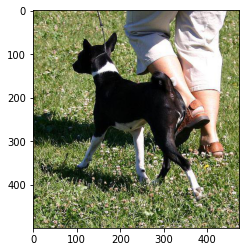

In [ ]:
plt.imshow(images[0])

In [ ]:
images_resized_dl.shape

(2184, 28227)

### Prepare labels data for model

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files:
    base = os.path.basename(pic)
    filename = os.path.splitext(base)[0]
    files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

(2184, 2)

### Train test split

In [ ]:
# Split train and test
X_dl = images_resized_dl
y_dl = df_labels['breed']

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size = 0.3, random_state = 42)
print(X_dl.shape, y_dl.shape)
print(X_train_dl.shape, X_test_dl.shape)
print(y_train_dl.shape, y_test_dl.shape)

(2184, 28227) (2184,)
(1528, 28227) (656, 28227)
(1528,) (656,)


In [ ]:
# input image dimensions for deep learning
img_rows, img_cols = IMG_DIM, IMG_DIM

X_train_dl = X_train_dl.reshape(X_train_dl.shape[0], img_rows, img_cols, 3)
X_test_dl = X_test_dl.reshape(X_test_dl.shape[0], img_rows, img_cols, 3)
input_shape_dl = (img_rows, img_cols, 3)

#normalize pixel intensities
# X_train /= 255
# X_test /= 255

print('Input shape:', input_shape_dl)
print('X_train shape:', X_train_dl.shape)
print(X_train_dl.shape[0], 'train samples')
print(X_test_dl.shape[0], 'test samples')

Input shape: (97, 97, 3)
X_train shape: (1528, 97, 97, 3)
1528 train samples
656 test samples


In [ ]:
test_labels = y_test_dl
num_classes = len(test_labels.unique())

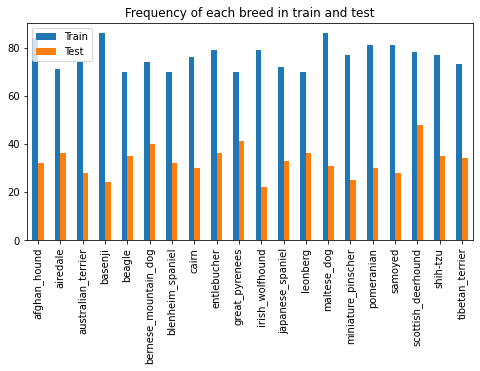

In [ ]:
df_y_train_dl = pd.Series(y_train_dl.value_counts(), name = 'Train')
df_y_test_dl = pd.Series(y_test_dl.value_counts(), name = 'Test')
df_dl = pd.concat([df_y_train_dl, df_y_test_dl], axis = 1, sort = True)
df_dl.plot(kind = 'bar', figsize = (8, 4), title = 'Frequency of each breed in train and test')
plt.show()

In [ ]:
# Create binarized labels for training
lb = LabelBinarizer()
y_train_dl = lb.fit_transform(y_train_dl)
y_test_dl = lb.fit_transform(y_test_dl)

print(y_train_dl.shape, 'train labels')
print(y_test_dl.shape, 'test labels')
y_train_dl[0]

(1528, 20) train labels
(656, 20) test labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_dl)

### Models

#### CNN built from scratch

In [ ]:
# Build CNN, using Keras Sequential API
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3),
                 activation = 'relu',
                 input_shape  = input_shape_dl))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 95, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 95, 95, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0

We first ran 200 epochs and get below accuracy plot
![image.png](attachment:image.png)
Then we trained the images with 400 epochs to see whether the accuracy scores were stable at some levels.

In [ ]:
from keras.callbacks import EarlyStopping
epochs = 400
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

In [ ]:
history = model.fit(datagen.flow(X_train_dl, y_train_dl, batch_size=32),
          steps_per_epoch=len(X_train_dl) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_dl, y_test_dl), callbacks=[es])

Epoch 1/400
48/47 [==============================] - 57s 1s/step - loss: 1.6547 - accuracy: 0.4620 - val_loss: 1.9100 - val_accuracy: 0.3841
Epoch 2/400
48/47 [==============================] - 57s 1s/step - loss: 1.6227 - accuracy: 0.4535 - val_loss: 1.8428 - val_accuracy: 0.4146
Epoch 3/400
48/47 [==============================] - 57s 1s/step - loss: 1.6209 - accuracy: 0.4601 - val_loss: 1.8128 - val_accuracy: 0.4360
Epoch 4/400
48/47 [==============================] - 57s 1s/step - loss: 1.6412 - accuracy: 0.4810 - val_loss: 1.8525 - val_accuracy: 0.4040
Epoch 5/400
48/47 [==============================] - 59s 1s/step - loss: 1.6329 - accuracy: 0.4666 - val_loss: 1.8539 - val_accuracy: 0.4284
Epoch 6/400
48/47 [==============================] - 57s 1s/step - loss: 1.6299 - accuracy: 0.4607 - val_loss: 1.9583 - val_accuracy: 0.4024
Epoch 7/400
48/47 [==============================] - 57s 1s/step - loss: 1.6435 - accuracy: 0.4535 - val_loss: 2.0215 - val_accuracy: 0.3643
Epoch 8/400
4

In [ ]:
score = model.evaluate(X_test_dl, y_test_dl, verbose=0)
print('Loss & Accuracy:', score)

Loss & Accuracy: [1.7299907207489014, 0.45121949911117554]


Text(0.5, 1.0, 'Accuracy Curves Basic CNN')

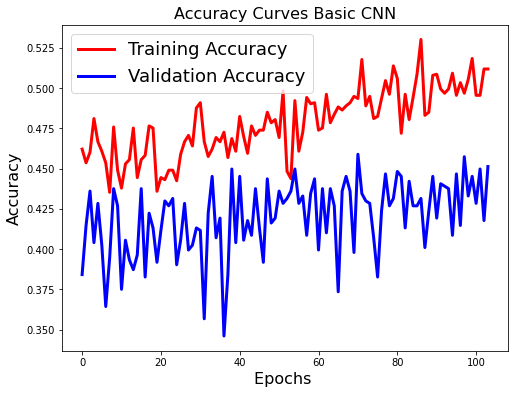

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Basic CNN',fontsize=16)

## Deep Learning Models - 224*224

### Resize the images and prepare for model

In [ ]:
IMG_DIM1 = 224

In [ ]:
# Resize the shape and prepare data for deep learning models
images_resized_dl1 = []

for i in images:
    img_resized = resize(i, (IMG_DIM1, IMG_DIM1))
    images_resized_dl1.append(img_resized.ravel())

images_resized_dl1 = np.asarray(images_resized_dl1)

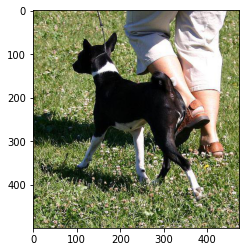

In [ ]:
plt.imshow(images[0])

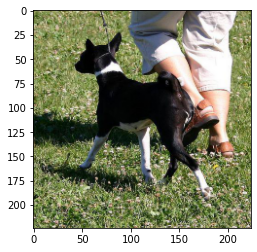

In [ ]:
plt.imshow(resize(images[0], (224, 224)))

In [ ]:
images_resized_dl1.shape

(2184, 150528)

### Prepare labels data for model

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files:
    base = os.path.basename(pic)
    filename = os.path.splitext(base)[0]
    files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

(2184, 2)

### Train test split

In [ ]:
# Split train and test
X_dl1 = images_resized_dl1
y_dl1 = df_labels['breed']

X_train_dl1, X_test_dl1, y_train_dl1, y_test_dl1 = train_test_split(X_dl1, y_dl1, test_size = 0.3, random_state = 42)
print(X_dl1.shape, y_dl1.shape)
print(X_train_dl1.shape, X_test_dl1.shape)
print(y_train_dl1.shape, y_test_dl1.shape)

(2184, 150528) (2184,)
(1528, 150528) (656, 150528)
(1528,) (656,)


In [ ]:
# input image dimensions for deep learning
img_rows1, img_cols1 = IMG_DIM1, IMG_DIM1

X_train_dl1 = X_train_dl1.reshape(X_train_dl1.shape[0], img_rows1, img_cols1, 3)
X_test_dl1 = X_test_dl1.reshape(X_test_dl1.shape[0], img_rows1, img_cols1, 3)
input_shape_dl1 = (img_rows1, img_cols1, 3)

#normalize pixel intensities
# X_train /= 255
# X_test /= 255

print('Input shape:', input_shape_dl1)
print('X_train shape:', X_train_dl1.shape)
print(X_train_dl1.shape[0], 'train samples')
print(X_test_dl1.shape[0], 'test samples')

Input shape: (224, 224, 3)
X_train shape: (1528, 224, 224, 3)
1528 train samples
656 test samples


In [ ]:
test_labels1 = y_test_dl1
num_classes = len(test_labels1.unique())
num_classes

20

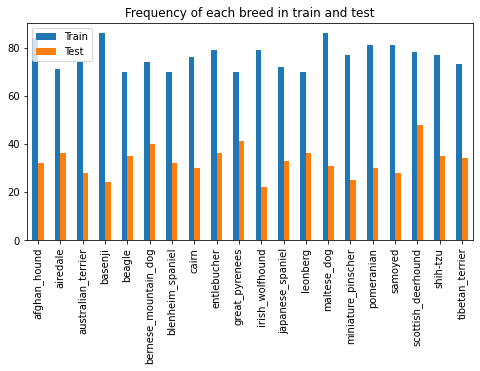

In [ ]:
df_y_train_dl1 = pd.Series(y_train_dl1.value_counts(), name = 'Train')
df_y_test_dl1 = pd.Series(y_test_dl1.value_counts(), name = 'Test')
df_dl1 = pd.concat([df_y_train_dl1, df_y_test_dl1], axis = 1, sort = True)
df_dl1.plot(kind = 'bar', figsize = (8, 4), title = 'Frequency of each breed in train and test')
plt.show()

In [ ]:
# Create binarized labels for training
lb = LabelBinarizer()
y_train_dl1 = lb.fit_transform(y_train_dl1)
y_test_dl1 = lb.fit_transform(y_test_dl1)

print(y_train_dl1.shape, 'train labels')
print(y_test_dl1.shape, 'test labels')
y_train_dl1[0]

(1528, 20) train labels
(656, 20) test labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#data augmentation
datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen1.fit(X_train_dl1)

### Models

#### CNN built from scratch

In [ ]:
# Build CNN, using Keras Sequential API
model2 = Sequential()
model2.add(Conv2D(32, kernel_size = (3,3),
                 activation = 'relu',
                 input_shape  = input_shape_dl1))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(256, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

In [ ]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [ ]:
from keras.callbacks import EarlyStopping
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [ ]:
history2 = model2.fit(datagen1.flow(X_train_dl1, y_train_dl1, batch_size=32),
          steps_per_epoch=len(X_train_dl1) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_dl1, y_test_dl1), callbacks=[es])

Epoch 1/200
48/47 [==============================] - 329s 7s/step - loss: 3.0547 - accuracy: 0.0458 - val_loss: 2.9962 - val_accuracy: 0.0366
Epoch 2/200
48/47 [==============================] - 325s 7s/step - loss: 2.9960 - accuracy: 0.0504 - val_loss: 2.9963 - val_accuracy: 0.0366
Epoch 3/200
48/47 [==============================] - 325s 7s/step - loss: 2.9912 - accuracy: 0.0497 - val_loss: 2.9964 - val_accuracy: 0.0366
Epoch 4/200
48/47 [==============================] - 324s 7s/step - loss: 2.9887 - accuracy: 0.0504 - val_loss: 2.9968 - val_accuracy: 0.0473
Epoch 5/200
48/47 [==============================] - 325s 7s/step - loss: 2.9718 - accuracy: 0.0700 - val_loss: 2.9961 - val_accuracy: 0.0457
Epoch 6/200
48/47 [==============================] - 324s 7s/step - loss: 2.9631 - accuracy: 0.0740 - val_loss: 2.9954 - val_accuracy: 0.0366
Epoch 7/200
48/47 [==============================] - 324s 7s/step - loss: 2.9402 - accuracy: 0.0805 - val_loss: 3.0044 - val_accuracy: 0.0335
Epoch 

#### Since the colab crashed, we only get the result of 125 epochs

In [ ]:
accuracy = [0.0458, 0.0504, 0.0497, 0.0504, 0.0700, 0.0740, 0.0805, 0.0838, 0.0759, 0.0897, 0.0949, 0.0962, 0.0897, 0.1086, 0.1283, 0.1158, 
           0.1283, 0.1276, 0.1407, 0.1355, 0.1466, 0.1361, 0.1531, 0.1401, 0.1584, 0.1551, 0.1545, 0.1682, 0.1669, 0.1754, 0.1787, 0.1649, 
           0.1865, 0.2042, 0.1950, 0.1708, 0.1976, 0.2022, 0.2186, 0.2120, 0.2166, 0.2147, 0.2094, 0.2212, 0.2421, 0.2219, 0.2356, 0.2310, 
           0.2565, 0.2389, 0.2526, 0.2539, 0.2526, 0.2611, 0.2559, 0.2631, 0.2886, 0.2664, 0.2572, 0.2592, 0.2598, 0.2827, 0.2821, 0.2631, 
           0.2801, 0.2801, 0.2755, 0.2723, 0.3076, 0.2880, 0.2899, 0.2762, 0.2801, 0.2886, 0.3037, 0.3089, 0.2978, 0.3024, 0.3010, 0.3331, 
           0.3024, 0.2991, 0.3024, 0.3338, 0.3096, 0.2945, 0.3266, 0.3135, 0.3455, 0.3213, 0.3560, 0.3128, 0.3259, 0.3089, 0.3344, 0.3082, 
           0.3423, 0.3482, 0.3691, 0.3514, 0.3606, 0.3632, 0.3737, 0.3534, 0.3704, 0.3501, 0.3802, 0.3606, 0.3829, 0.3613, 0.3757, 0.3717, 
           0.3789, 0.3907, 0.4005, 0.3861, 0.3796, 0.4031, 0.3763, 0.4110, 0.4077, 0.3927, 0.3907, 0.3927]

val_accuracy = [0.0366, 0.0366, 0.0366, 0.0473, 0.0457, 0.0366, 0.0335, 0.0412, 0.0549, 0.0793, 0.1037, 0.0701, 0.0884, 0.1524, 0.0640, 0.0899, 0.1372, 0.1037,
                0.0915, 0.1326, 0.1631, 0.1311, 0.1220, 0.1159, 0.1875, 0.2027, 0.1738, 0.1936, 0.1738, 0.2134, 0.2256, 0.1799, 0.1616, 0.1738, 0.1768, 0.1753, 
                0.2332, 0.1509, 0.1936, 0.1738, 0.2149, 0.2012, 0.2134, 0.2104, 0.1723, 0.2393, 0.1966, 0.2393, 0.2134, 0.2454, 0.1753, 0.2256, 0.2790, 0.2180,
                0.1997, 0.2470, 0.2256, 0.2698, 0.2470, 0.2591, 0.2409, 0.2561, 0.2454, 0.2210, 0.2683, 0.2942, 0.2226, 0.3064, 0.2104, 0.2927, 0.2180, 0.3003, 
                0.3232, 0.3018, 0.3049, 0.2820, 0.2104, 0.2973, 0.2927, 0.2957, 0.2942, 0.2835, 0.2409, 0.3003, 0.3384, 0.3201, 0.3079, 0.3262, 0.3018, 0.2927, 
                0.3308, 0.3491, 0.2591, 0.3552, 0.2500, 0.2668, 0.2439, 0.3262, 0.3216, 0.3643, 0.2622, 0.3384, 0.2973, 0.3216, 0.2896, 0.3186, 0.3354, 0.2957, 
                0.3338, 0.3537, 0.3262, 0.2652, 0.3262, 0.3338, 0.3491, 0.3872, 0.3216, 0.3613, 0.3765, 0.3216, 0.3552, 0.3628, 0.3171, 0.3064]

Text(0.5, 1.0, 'Accuracy Curves Basic CNN')

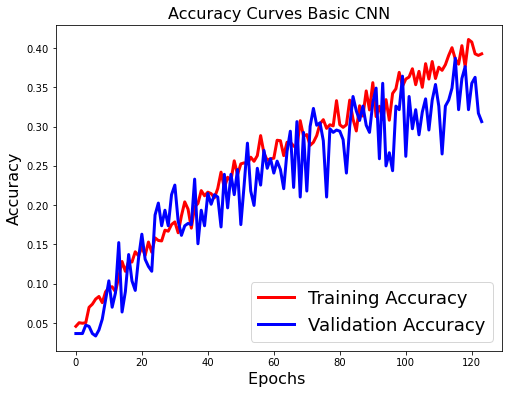

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

accuracy = np.asarray(accuracy)
accuracy.reshape(124, 1)

val_accuracy = np.asarray(val_accuracy)
val_accuracy.reshape(124,1)

plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18, loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Basic CNN',fontsize=16)